In [1]:
import pandas as pd
import numpy as np
import pybaseball as py
from pybaseball import statcast
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold
import optuna
import pickle


In [5]:
start_dt = "2023-04-01"
end_dt = "2024-09-30"

data = statcast(start_dt=start_dt, end_dt=end_dt)

This is a large query, it may take a moment to complete


/Users/aidanbeilke/anaconda3/lib/python3.11/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


  0%|          | 0/429 [00:00<?, ?it/s]/Users/aidanbeilke/anaconda3/lib/python3.11/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  0%|          | 1/429 [00:02<15:18,  2.15s/it]/Users/aidanbeilke/anaconda3/lib/python3.11/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  0%|          | 2/429 [00:02<07:13,  1.02s/it]/Users/aidanbeilke/anaconda3/lib/python3.11/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is de

In [6]:
data.shape

(1468747, 113)

In [7]:
player_height = pd.read_csv("/Users/aidanbeilke/Desktop/Purdue_Base/newman_proj/csvs/mlb_height.csv")

player_height.shape

(1388, 3)

In [8]:
player_height

,id,full_name,height
0,669194,Ryne Nelson,"6' 3"""
1,673513,Yuki Matsui,"5' 8"""
2,663362,Matt Waldron,"6' 2"""
3,573009,Joe Mantiply,"6' 4"""
4,694297,Brandon Pfaadt,"6' 4"""
...,...,...,...
1383,642578,José Rodríguez,"6' 2"""
1384,681987,Nate Eaton,"5' 10"""
1385,676050,Packy Naughton,"6' 2"""
1386,607461,Matt Beaty,"6' 0"""


In [9]:
def height_to_inches(height):
    parts = height.split("'")
    feet = int(parts[0].strip())
    inches = int(parts[1].replace('"', '').strip())
    return (feet * 12) + inches

def format_name(name):
    last, first = name.split(", ")
    # Reorder and return
    return f"{first} {last}"

player_height['height_in_inches'] = player_height['height'].apply(height_to_inches)
data['full_name'] = data['player_name'].apply(format_name)

In [10]:
player_height

,id,full_name,height,height_in_inches
0,669194,Ryne Nelson,"6' 3""",75
1,673513,Yuki Matsui,"5' 8""",68
2,663362,Matt Waldron,"6' 2""",74
3,573009,Joe Mantiply,"6' 4""",76
4,694297,Brandon Pfaadt,"6' 4""",76
...,...,...,...,...
1383,642578,José Rodríguez,"6' 2""",74
1384,681987,Nate Eaton,"5' 10""",70
1385,676050,Packy Naughton,"6' 2""",74
1386,607461,Matt Beaty,"6' 0""",72


In [11]:
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,full_name
201,FF,2024-09-30,97.4,-2.1,4.88,"Díaz, Edwin",518595,621242,field_out,hit_into_play,...,4,1,1,3,1,1.4,0.96,0.96,17.6,Edwin Díaz
204,SL,2024-09-30,90.7,-2.14,5.06,"Díaz, Edwin",518595,621242,NaN,ball,...,4,1,1,3,1,2.14,-0.2,-0.2,23.1,Edwin Díaz
209,SL,2024-09-30,91.1,-2.07,5.14,"Díaz, Edwin",518595,621242,NaN,swinging_strike,...,4,1,1,3,1,2.37,-0.12,-0.12,22.4,Edwin Díaz
217,SL,2024-09-30,91.3,-2.05,5.07,"Díaz, Edwin",518595,621242,NaN,ball,...,4,1,1,3,1,2.09,-0.21,-0.21,22.4,Edwin Díaz
222,SL,2024-09-30,89.1,-2.13,5.15,"Díaz, Edwin",518595,621242,NaN,swinging_strike,...,4,1,1,3,1,2.2,-0.17,-0.17,20.2,Edwin Díaz


In [12]:
all = data.merge(player_height, on = 'full_name', how = 'left')

In [13]:
all[['full_name', 'height', 'height_in_inches']].drop_duplicates()

,full_name,height,height_in_inches
0,Edwin Díaz,"6' 3""",75
19,Pierce Johnson,"6' 2""",74
61,Phil Maton,"6' 2""",74
73,Aaron Bummer,"6' 3""",75
86,Raisel Iglesias,"6' 2""",74
...,...,...,...
1433269,José Rodríguez,"6' 2""",74
1437952,Nate Eaton,"5' 10""",70
1451249,Packy Naughton,"6' 2""",74
1452693,Matt Beaty,"6' 0""",72


In [14]:
# Remove Position Players
all = all[all['release_speed'] >= 70].copy()

all

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,full_name,id,height,height_in_inches
0,FF,2024-09-30,97.4,-2.1,4.88,"Díaz, Edwin",518595,621242,field_out,hit_into_play,...,3,1,1.4,0.96,0.96,17.6,Edwin Díaz,621242,"6' 3""",75
1,SL,2024-09-30,90.7,-2.14,5.06,"Díaz, Edwin",518595,621242,NaN,ball,...,3,1,2.14,-0.2,-0.2,23.1,Edwin Díaz,621242,"6' 3""",75
2,SL,2024-09-30,91.1,-2.07,5.14,"Díaz, Edwin",518595,621242,NaN,swinging_strike,...,3,1,2.37,-0.12,-0.12,22.4,Edwin Díaz,621242,"6' 3""",75
3,SL,2024-09-30,91.3,-2.05,5.07,"Díaz, Edwin",518595,621242,NaN,ball,...,3,1,2.09,-0.21,-0.21,22.4,Edwin Díaz,621242,"6' 3""",75
4,SL,2024-09-30,89.1,-2.13,5.15,"Díaz, Edwin",518595,621242,NaN,swinging_strike,...,3,1,2.2,-0.17,-0.17,20.2,Edwin Díaz,621242,"6' 3""",75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475111,FF,2023-04-01,96.0,-0.64,6.25,"Gilbert, Logan",642708,669302,NaN,called_strike,...,6,1,0.82,0.15,0.15,61.6,Logan Gilbert,669302,"6' 6""",78
1475112,FF,2023-04-01,96.4,-0.73,6.23,"Gilbert, Logan",680757,669302,strikeout,called_strike,...,6,1,0.69,0.51,-0.51,66.4,Logan Gilbert,669302,"6' 6""",78
1475113,FF,2023-04-01,97.3,-0.72,6.26,"Gilbert, Logan",680757,669302,NaN,ball,...,6,1,0.77,0.24,-0.24,59.9,Logan Gilbert,669302,"6' 6""",78
1475114,FF,2023-04-01,96.5,-0.6,6.38,"Gilbert, Logan",680757,669302,NaN,foul,...,6,1,0.96,0.23,-0.23,60.8,Logan Gilbert,669302,"6' 6""",78


## Arm Angle Modeling Process

In [15]:
feats =  ['release_pos_x', 'release_pos_z', 'release_extension', 'height_in_inches']

print(all[feats].dtypes)

release_pos_x        Float64
release_pos_z        Float64
release_extension    Float64
height_in_inches       int64
dtype: object


In [16]:
all[feats].isna().sum()

release_pos_x           0
release_pos_z           0
release_extension    1761
height_in_inches        0
dtype: int64

In [17]:
important_vars = feats + ['arm_angle']
print(all.shape)
all = all.dropna(subset=important_vars).copy()
print(all.shape)

(1456517, 117)
(1426059, 117)


In [18]:
all[important_vars].isna().sum()

release_pos_x        0
release_pos_z        0
release_extension    0
height_in_inches     0
arm_angle            0
dtype: int64

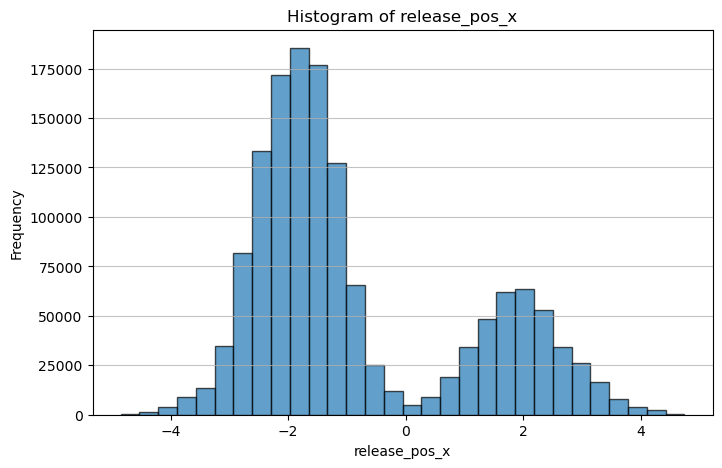

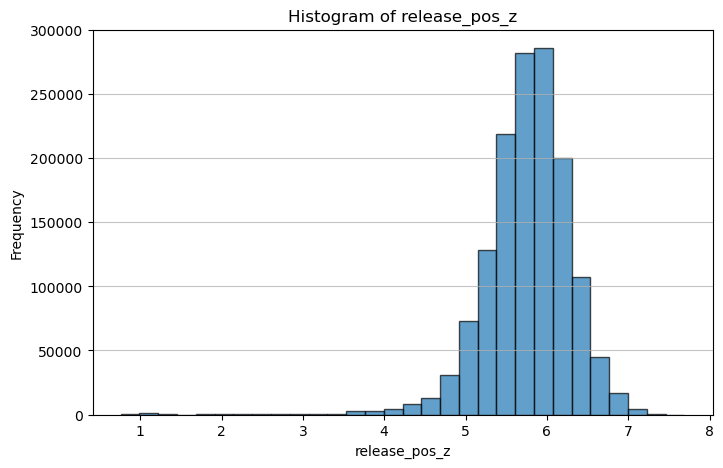

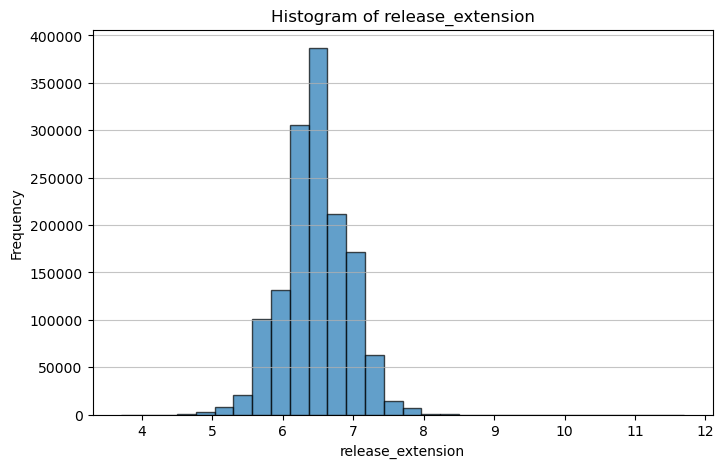

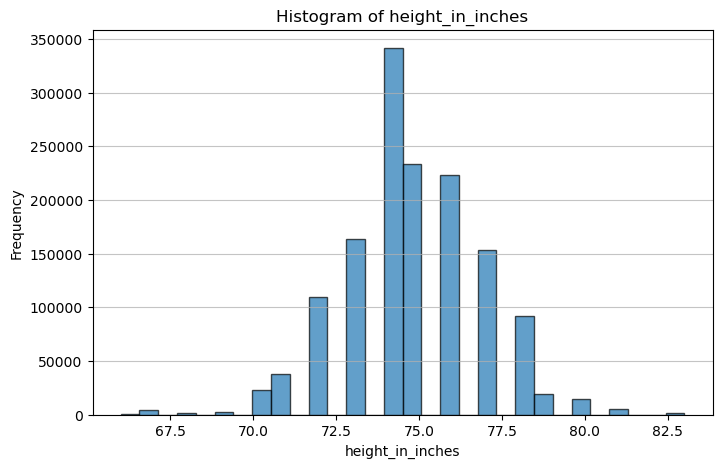

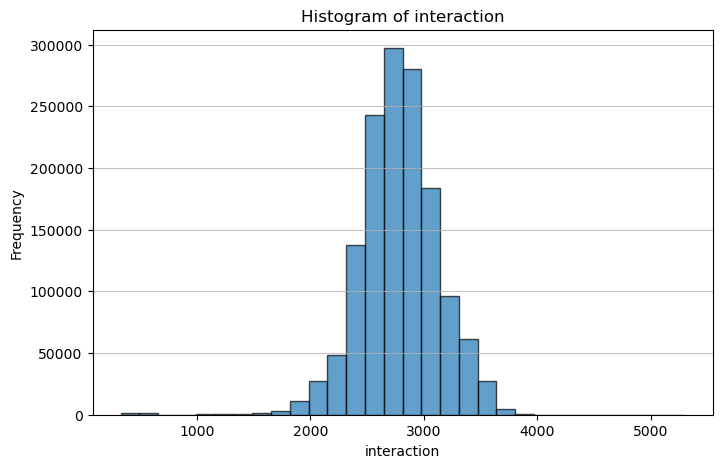

In [19]:
all['interaction'] =  all['release_pos_z'] * all['release_extension'] * all['height_in_inches']
feats = feats + ['interaction']

for feature in feats:
    plt.figure(figsize=(8, 5))
    plt.hist(all[feature], bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [20]:
X = all[feats]
y = all['arm_angle']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1140847, 5)
(285212, 5)
(1140847,)
(285212,)


In [21]:
all['arm_angle'].describe()

count    1426059.0
mean     38.436536
std      12.911439
min          -71.2
25%           31.2
50%           39.6
75%           46.8
max          144.0
Name: arm_angle, dtype: Float64

### Linear Regression (No Scale)

In [80]:
model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

RMSE: 6.68


### Catboost

In [ ]:
best_rmse = float('inf')
best_catboost_model = None

def catboost_objective(trial):
    global best_rmse, best_catboost_model

    # Define hyperparameters for optimization
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 1e-1, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
    }

    # Select top features based on importance
    X_top_features = X[feats]

    cv = KFold(n_splits=5, shuffle=True, random_state=13)
    cv_scores = []

    for train_idx, val_idx in cv.split(X_top_features, y):
        cat_X_train, cat_X_val = X_top_features.iloc[train_idx], X_top_features.iloc[val_idx]
        cat_y_train, cat_y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the CatBoost model
        catboost_model = CatBoostRegressor(**params, random_seed=13, verbose=0)
        catboost_model.fit(cat_X_train, cat_y_train, eval_set=(cat_X_val, cat_y_val), early_stopping_rounds=50, verbose=0)

        cat_y_pred = catboost_model.predict(cat_X_val)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(cat_y_val, cat_y_pred))
        cv_scores.append(rmse)

    mean_rmse = np.mean(cv_scores)

    # Save the best model based on RMSE
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_catboost_model = catboost_model

    return mean_rmse

# Create and run Optuna study, optimizing to minimize RMSE
catboost_study = optuna.create_study(direction='minimize')  
catboost_study.optimize(catboost_objective, n_trials=25)

# Get the best hyperparameters from the Optuna study
best_catboost_params = catboost_study.best_params
print("Best CatBoost Params:", best_catboost_params)

[I 2024-12-30 18:25:52,473] A new study created in memory with name: no-name-9338a502-46f8-467d-9e04-6c0aa7347281
[I 2024-12-30 18:26:34,188] Trial 0 finished with value: 8.213649482651352 and parameters: {'iterations': 332, 'learning_rate': 0.011089356121247042, 'depth': 1, 'min_data_in_leaf': 30, 'l2_leaf_reg': 0.31027131688199644, 'border_count': 165, 'bagging_temperature': 0.10450835121647481, 'random_strength': 0.25919421145305277}. Best is trial 0 with value: 8.213649482651352.
[I 2024-12-30 18:29:51,960] Trial 1 finished with value: 7.4222380444561695 and parameters: {'iterations': 676, 'learning_rate': 0.001669171941787976, 'depth': 10, 'min_data_in_leaf': 23, 'l2_leaf_reg': 0.002627537665718108, 'border_count': 159, 'bagging_temperature': 8.499544266201411, 'random_strength': 0.03679668485043289}. Best is trial 1 with value: 7.4222380444561695.
[I 2024-12-30 18:31:12,462] Trial 2 finished with value: 6.231529204613753 and parameters: {'iterations': 515, 'learning_rate': 0.0083

Best CatBoost Params: {'iterations': 1318, 'learning_rate': 0.05192685540119166, 'depth': 10, 'min_data_in_leaf': 67, 'l2_leaf_reg': 0.00608395928607933, 'border_count': 92, 'bagging_temperature': 4.701512162088607, 'random_strength': 2.7816974298389865}


In [83]:
with open("best_catboost_model.pkl", "wb") as f:
    pickle.dump(best_catboost_model, f)

print("Best CatBoost model saved as 'best_catboost_model.pkl'")

Best CatBoost model saved as 'best_catboost_model.pkl'
